# Resacmpling Methods

In [1]:
import pandas as pd
import numpy as np

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
auto_data = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
# Set up data for 10 split and run regression on each one of them
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# Create coordinate arrays using the mesh grid function
X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

# Initialize regression
regr = skl_lm.LinearRegression()

# Loop through and generate 10 splits
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(auto_data.horsepower.values.reshape(-1,1))
    
    # Generate our input for regression
    X_train, X_test, y_train, y_test = train_test_split(X_poly,
                                                        auto_data.mpg.ravel(),
                                                        test_size=t_prop,
                                                        random_state=Y[i,j]
                                                        )
    # Fit the model, predict and store the results                                                                
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

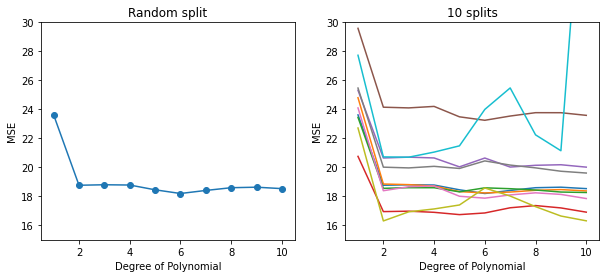

In [6]:
# Plot the results from all the splits
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# First fig is the first split
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split')

# Second figure (all splits)
ax2.plot(X,Z)
ax2.set_title('10 splits')

for ax in fig.axes:
    ax.set_ylabel('MSE')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

## K-fold validation vs leave one out

In [7]:
#generate results using leave on out cross validation
p_order = np.arange(1,11)
r_state = np.arange(0,10)

regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(auto_data)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(auto_data.horsepower.values.reshape(-1,1))
    score = cross_val_score(
        regr,
        X_poly,
        auto_data.mpg,
        cv=loo,
        scoring='neg_mean_squared_error'
        ).mean()
    scores.append(score)

In [9]:
# Run the same for K-fold
folds = 10
elements = len(auto_data.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(auto_data.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j])
    Z[i,j] = cross_val_score(
        regr,
        X_poly,
        auto_data.mpg,
        cv=kf_10,
        scoring='neg_mean_squared_error'
        ).mean()

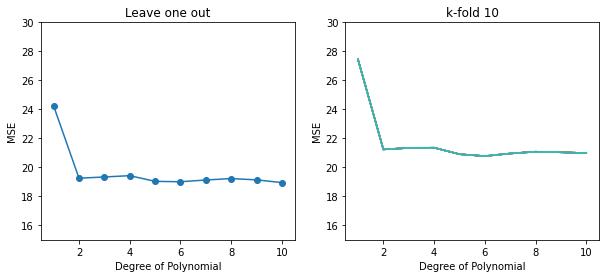

In [10]:
# Plot the comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('Leave one out')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('k-fold 10')

for ax in fig.axes:
    ax.set_ylabel('MSE')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2))